# Using Machine Learning Tools 2024, Assignment 3

## Sign Language Image Classification using Deep Learning

## Overview

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The main aims of the assignment are:

 - To implement and train different types of deep learning network;
 
 - To systematically optimise the architecture and parameters of the networks;
  
 - To explore under- or over-fitting and know what appropriate actions to take in these cases.
 

During this assignment you will go through the process of implementing and optimising deep learning approaches. The way that you work is more important than the results for this assignment, as what is most crucial for you to learn is how to take a dataset, understand the problem, write appropriate code, optimize performance and present results. A good understanding of the different aspects of this process and how to put them together well (which will not always be the same, since different problems come with different constraints or difficulties) is the key to being able to effectively use deep learning techniques in practice.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, and programming.


## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled dataset of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 50 training runs in total** (where one training run consists of fitting a DL model, with as many epochs as you think are needed, and with fixed model specifications and fixed hyperparameter settings - that is, not including hyper-parameter optimisation). In addition, because it is intended to be for a lightweight app, your manager wants to to **limit the number of total parameters in each network to a maximum of 500,000.** Also, the data has already been double-checked for problems by an in-house data wrangling team and all erroneous data has already been identified and then fixed by the client, so you **do not need to check for erroneous data** in this case.

In addition, you are told to **create a fixed validation set and any necessary test sets using _only_ the supplied _testing_ dataset.** It is unusual to do this, but here the training set contains a lot of non-independent, augmented images and it is important that the validation images must be totally independent of the training data and not made from augmented instances of training images.

The clients have asked to be informed about the following:
 - **unbiased median accuracy** estimate of the letter predictions from a deep learning model
 - the letter with the highest individual accuracy
 - the letter with the lowest individual accuracy
 - the three most common single types of error (i.e. where one letter is being incorrectly labelled as another)
 
Your manager has asked you to create a jupyter notebook that shows the following:
 - loading the data and displaying a sample of each letter
 - training and optimising both **densely connected** *and* **CNN** style models
 - finding the best single model, subject to a rapid turn-around and corresponding limit of 50 training runs in total
 - reporting clearly and concisely what networks you have tried, the method you used to optimise them, the associated learning curves, the number of total parameters in each, their summary performance and the selection process used to pick the best model
     - this should be clear enough that another employee, with your skillset, should be able to take over from you and understand your code and your methods
 - results from the model that is selected as the best, showing the information that the clients have requested
 - it is hoped that the median accuracy will exceed 94% overall and better than 85% for every individual letter, and you are asked to report (in addition to the client's requests):
     - the overall mean accuracy
     - the accuracy for each individual letter
     - a short written recommendation (100 words maximum) regarding how likely you think it is to achieve these goals either with the current model or by continuing to do a small amount of model development/optimisation


# Data Loading, Exploration and Baseline

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()


In [2]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
import pandas as pd

# Load the training dataset for sign language
df_train = pd.read_csv("sign_mnist_train.csv")

# Open the test dataset for sign language.
df_test = pd.read_csv("sign_mnist_test.csv")

# Show the training dataset's initial few rows.
print(df_train.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     157     157     157     157     157     158   
2      2     187     188     188     188     188     188     188     188   
3      2     211     211     212     212     212     212     212     212   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel1015  pixel1016  pixel1017  pixel1018  pixel1019  \
0     153  ...        207        207        207        207        206   
1     158  ...        149        163        175        175        175   
2     188  ...        202        201        200        199        199   
3     211  ...        235        234        233        231        230   
4     185  ...        133        163        163        163        164   

   pixel1020  pixel1021  pixel1022  pixel1023  pixel1024  
0        206        206        204        203

In [4]:
# Show the names of the first few columns.
print(df_train.columns)

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel1015', 'pixel1016', 'pixel1017', 'pixel1018', 'pixel1019',
       'pixel1020', 'pixel1021', 'pixel1022', 'pixel1023', 'pixel1024'],
      dtype='object', length=1025)


In [5]:
# Show the test dataset's initial few rows.
print(df_test.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     151   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     207     207     209     210     210   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel1015  pixel1016  pixel1017  pixel1018  pixel1019  \
0     151  ...        148        148        127        112        120   
1     136  ...        194        194        194        186        186   
2     147  ...        242        242        242        230        230   
3     210  ...        253        253        253        253        253   
4     203  ...         64         64         64         49         49   

   pixel1020  pixel1021  pixel1022  pixel1023  pixel1024  
0        120        120        120        120

In [6]:
# Let's see how big it is
print(df_train.shape)
print(df_test.shape)

(27455, 1025)
(7172, 1025)


In [7]:
n_total_train = df_train.shape[0]
n_total_test = df_test.shape[0]
print(f"Total number of training samples: {n_total_train}")
print(f"Total number of test samples: {n_total_test}")

Total number of training samples: 27455
Total number of test samples: 7172


In [8]:
print(df_train["label"].value_counts())

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64


In [9]:
# Separate features and labels
X_train_full = df_train.iloc[:, 1:].values
y_train_full = df_train.iloc[:, 0].values

X_test_full = df_test.iloc[:, 1:].values
y_test_full = df_test.iloc[:, 0].values

In [10]:
# Verify the features to ascertain the image's proportions.
num_features = X_train_full.shape[1]
print(f"Number of features (pixels) per image: {num_features}")

Number of features (pixels) per image: 1024


In [11]:
# Assuming the images are square
image_dim = int(np.sqrt(num_features))
print(f"Assumed image dimensions: {image_dim}x{image_dim}")

Assumed image dimensions: 32x32


In [12]:
# Resize the data to the appropriate proportions.
X_train_full = X_train_full.reshape(-1, image_dim, image_dim)
X_test_full = X_test_full.reshape(-1, image_dim, image_dim)

In [13]:
unique_classes = np.unique(y_train_full)
print("Unique classes:", unique_classes)

Unique classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [14]:
# Update class_names array to match the unique classes in your dataset
class_names = np.array([str(i) for i in unique_classes])

# Check the shape of individual images before reshaping
print("Shape of a single image before reshaping:", X_train_full[0].shape)

Shape of a single image before reshaping: (32, 32)


In [15]:
# Check the shape of the entire dataset
print("Shape of the training dataset:", X_train_full.shape)
print("Shape of the test dataset:", X_test_full.shape)


Shape of the training dataset: (27455, 32, 32)
Shape of the test dataset: (7172, 32, 32)


In [16]:
# Reshape the features to match the expected input shape (32x32 images)
X_train_full = X_train_full.reshape(-1, 32, 32, 1)
X_test_full = X_test_full.reshape(-1, 32, 32, 1)

# Now, check the shape again
print("Shape of a single training image after reshaping:", X_train_full[0].shape)
print("Shape of a single test image after reshaping:", X_test_full[0].shape)


Shape of a single training image after reshaping: (32, 32, 1)
Shape of a single test image after reshaping: (32, 32, 1)


In [ ]:
# Scale the data properly (we want a maximum of 1, not 255, which is where it starts).
# Although we could create a pipeline scaler for this, we shall handle this "by hand" in this instance.
# We additionally divided the provided training set into subsets for training and validation.
# The selection of 5000 samples as the validation set's size is arbitrary.
# Crucial: There is no data leakage because this scaling is fixed (by dividing by 255), not suited to the data. 
#Since the scaling factor is constant and independent of the dataset, data leaking is not a concern in this case.

Additionally, we divided the provided training set into subsets for training and validation. The validation set's size of 5000 samples was chosen at random.

# Scale the training and testing data by dividing the pixel values by 255 to normalize them.
X_train = X_train_full / 255.0
X_test = X_test_full / 255.0

# From the testing dataset, create a fixed validation set.
X_valid, X_test = X_test[:5000], X_test[5000:]
y_valid, y_test = y_test_full[:5000], y_test_full[5000:]

# The training data remains the same
y_train = y_train_full

# Update class_names array to match the unique classes in your dataset
unique_classes = np.unique(y_train)
class_names = np.array([str(i) for i in unique_classes])

# Inspect some aspects of the data
print(X_train.dtype)
print(X_valid.dtype)


label_index = np.where(unique_classes == y_train[2])[0][0]  
print(f"Class label of the third training image: {class_names[label_index]}")
plt.imshow(X_train[2, :, :], cmap='gray')
plt.grid(False)
plt.show()


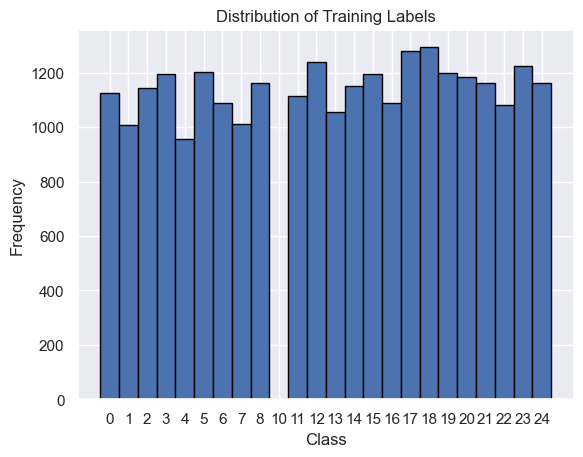

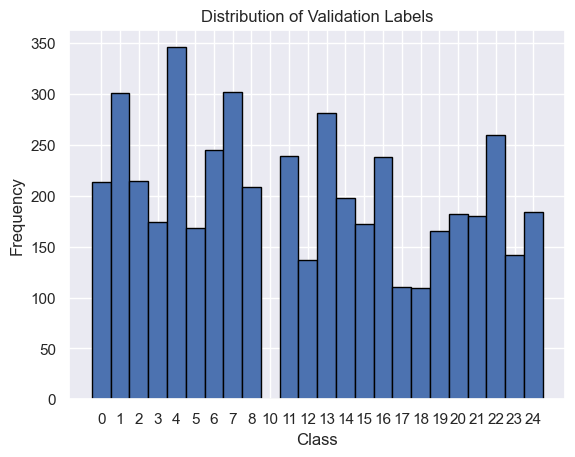

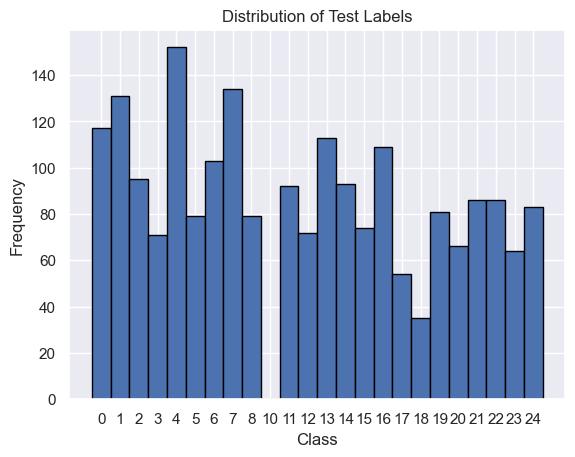

In [18]:
#Plotting the y_train histogram
plt.hist(y_train, bins=np.arange(25)-0.5, edgecolor='black')  # 24 bins for 24 classes
plt.title('Distribution of Training Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(24), labels=class_names)  # Set x-axis ticks to class names (A-Y)
plt.show()

# Plotting the histogram for y_valid
plt.hist(y_valid, bins=np.arange(25)-0.5, edgecolor='black')
plt.title('Distribution of Validation Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(24), labels=class_names)
plt.show()

# Plotting the y_test histogram
plt.hist(y_test, bins=np.arange(25)-0.5, edgecolor='black')
plt.title('Distribution of Test Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(24), labels=class_names)
plt.show()



In [19]:
from keras.utils import to_categorical
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [20]:
# Create a model
model = keras.models.Sequential()

# 1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation="elu", padding="same",
                              input_shape=[32, 32, 1]))  # Adjusted input shape to [32, 32, 1]
model.add(keras.layers.MaxPooling2D(pool_size=2))  # Pool (downsize)

# 2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="elu"))
model.add(keras.layers.MaxPooling2D(pool_size=2))  # Pool (downsize)

# Flatten the convolutional layers' output
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(50, activation="elu"))

# Softmax activation for multi-class classification in the output layer
model.add(keras.layers.Dense(25, activation="softmax"))  # Adjusted to 24 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Users/harish/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
#Convert labels to one-hot encoded categories.
y_train_categorical = to_categorical(y_train, num_classes=25)
y_valid_categorical = to_categorical(y_valid, num_classes=25)
y_test_categorical = to_categorical(y_test, num_classes=25)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       102,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,525 (423.93 KB)

 Trainable params: 108,525 (423.93 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Check unique labels before any modifications
print("Unique labels before modification:", np.unique(y_train_full))

Unique labels before modification: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [24]:
y_train_categorical.shape

(27455, 25)

In [25]:
X_test.shape,y_test_categorical.shape

((2172, 32, 32, 1), (2172, 25))

In [26]:
# Now, we can compile the model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])

# We can train in our model
history = model.fit(X_train,y_train_categorical, epochs=5, validation_data=(X_valid, y_valid_categorical), batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0382 - loss: 3.2046 - val_accuracy: 0.0548 - val_loss: 3.1875
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0591 - loss: 3.1572 - val_accuracy: 0.0788 - val_loss: 3.1575
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1218 - loss: 3.1165 - val_accuracy: 0.1366 - val_loss: 3.0963
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1755 - loss: 3.0531 - val_accuracy: 0.2030 - val_loss: 3.0075
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2114 - loss: 2.9370 - val_accuracy: 0.2302 - val_loss: 2.8340
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2434 - loss: 2.8060
Test accuracy: 23.20%


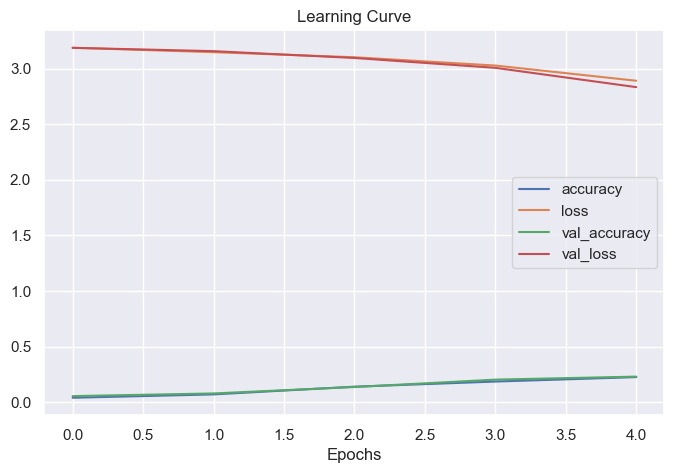

In [27]:
 #We can use a plot to evaluate our model's performance.
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.grid(True)  
plt.legend(loc='best')  
plt.show()


In [28]:
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=25)
y_valid_categorical = to_categorical(y_valid, num_classes=25)

# Build the deep neural network
model_dnn = Sequential()
# Flatten the input data at the input layer.
model_dnn.add(Flatten(input_shape=(32, 32, 1)))  

# Hidden Layer: Include one Dense layer activated by ReLU.
model_dnn.add(Dense(64, activation='relu'))

# Output Layer: Verify that the output layer contains the appropriate quantity of neurons.
model_dnn.add(Dense(25, activation='softmax'))  

# Compile the model
model_dnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Use the training data to train the model
history_dnn = model_dnn.fit(X_train, y_train_categorical, 
                            validation_data=(X_valid, y_valid_categorical), 
                            epochs=5,  
                            batch_size=32)



/Users/harish/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1497 - loss: 2.8916 - val_accuracy: 0.3196 - val_loss: 2.1024
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.4151 - loss: 1.8914 - val_accuracy: 0.4136 - val_loss: 1.7926
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5178 - loss: 1.5514 - val_accuracy: 0.5072 - val_loss: 1.5780
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.5667 - loss: 1.3777 - val_accuracy: 0.5202 - val_loss: 1.5097
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.6056 - loss: 1.2470 - val_accuracy: 0.5140 - val_loss: 1.5651


In [29]:
# Compile the model
model_dnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


In [30]:
# Train the model on the validation data
history_dnn = model_dnn.fit(X_valid, y_valid_categorical, 
                            validation_data=(X_train, y_train_categorical), 
                            epochs=5,  
                            batch_size=32)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5671 - loss: 1.4056 - val_accuracy: 0.5076 - val_loss: 1.4505
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5912 - loss: 1.2915 - val_accuracy: 0.5906 - val_loss: 1.2601
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6242 - loss: 1.1797 - val_accuracy: 0.5646 - val_loss: 1.2921
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6623 - loss: 1.0798 - val_accuracy: 0.5530 - val_loss: 1.3085
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6803 - loss: 1.0302 - val_accuracy: 0.5329 - val_loss: 1.3603


In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_dnn.evaluate(X_test, to_categorical(y_test, num_classes=25))
print(f'Test accuracy: {test_accuracy:.4f}')


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6387 - loss: 1.0675
Test accuracy: 0.6400


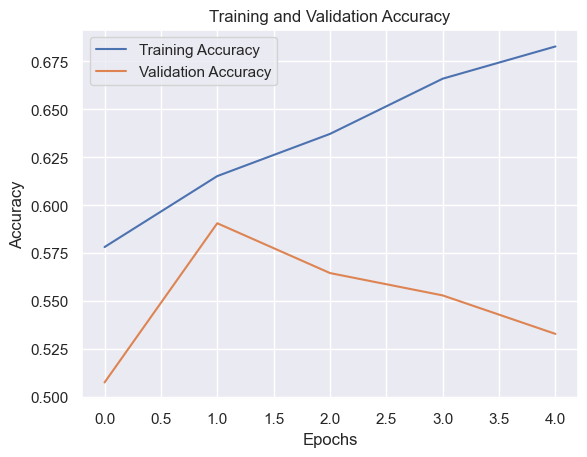

In [32]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


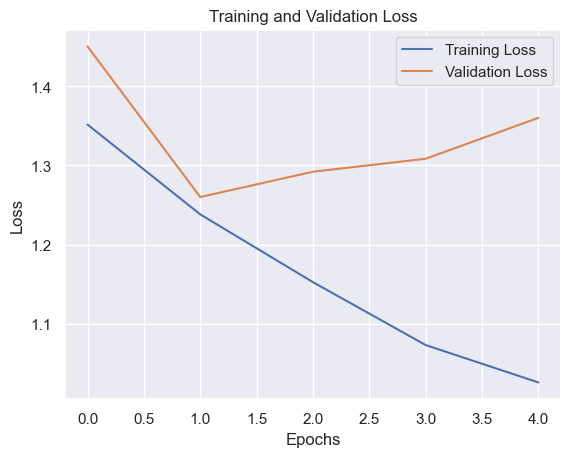

In [33]:
# Plot the training and validation loss
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Hyper-Parameter Optimisation

# CNN

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, Dropout

# Define the number of classes
num_classes = 25  

# Define your CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    
    model.add(Flatten())
    model.add(Dense(units=512, activation="relu"))
    model.add(Dropout(0.7))
    model.add(Dense(units=num_classes, activation="softmax"))  # Use num_classes here
    
    return model

# Create and summarize the model
model_optimized_cnn = create_cnn_model()
model_optimized_cnn.summary()

learning_rate = 0.00001

model_optimized_cnn.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
history_optimized = model_optimized_cnn.fit(X_train, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_valid, y_valid_categorical))

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,787 (6.43 MB)

 Trainable params: 1,686,537 (6.43 MB)

 Non-trainable params: 250 (1000.00 B)

Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.0885 - loss: 4.9063 - val_accuracy: 0.2228 - val_loss: 2.7770
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.3024 - loss: 2.3657 - val_accuracy: 0.6062 - val_loss: 1.6384
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4847 - loss: 1.7223 - val_accuracy: 0.6794 - val_loss: 1.2342
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.6104 - loss: 1.2919 - val_accuracy: 0.7408 - val_loss: 0.9651
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6943 - loss: 1.0184 - val_accuracy: 0.7774 - val_loss: 0.7964
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.7594 - loss: 0.8100 - val_accuracy: 0.8132 - val_loss: 0.6726
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8067 - loss: 0.6552 - val_accuracy: 0.8242 - val_loss: 0.5911
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8430 - loss: 0.5340 - 

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9301 - loss: 0.2942
Test accuracy: 93.09%


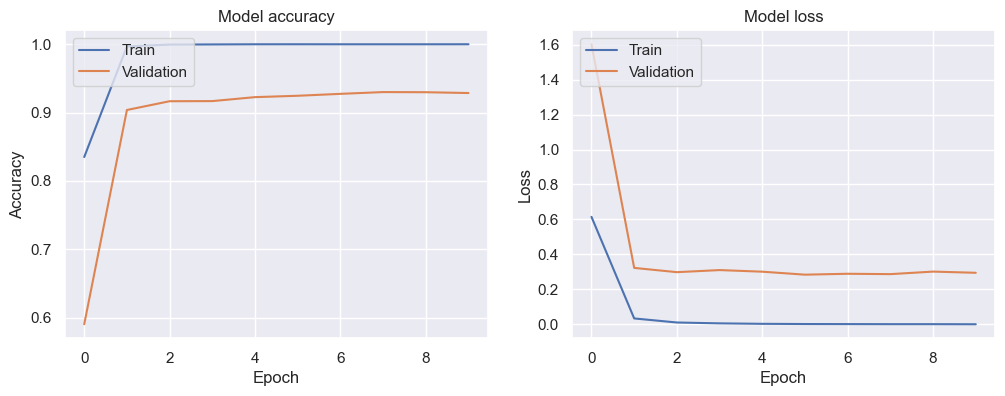

In [68]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_optimized_cnn.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_optimized.history['accuracy'])
plt.plot(history_optimized.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_optimized.history['loss'])
plt.plot(history_optimized.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8744 - loss: 0.4084
Test accuracy: 87.34%


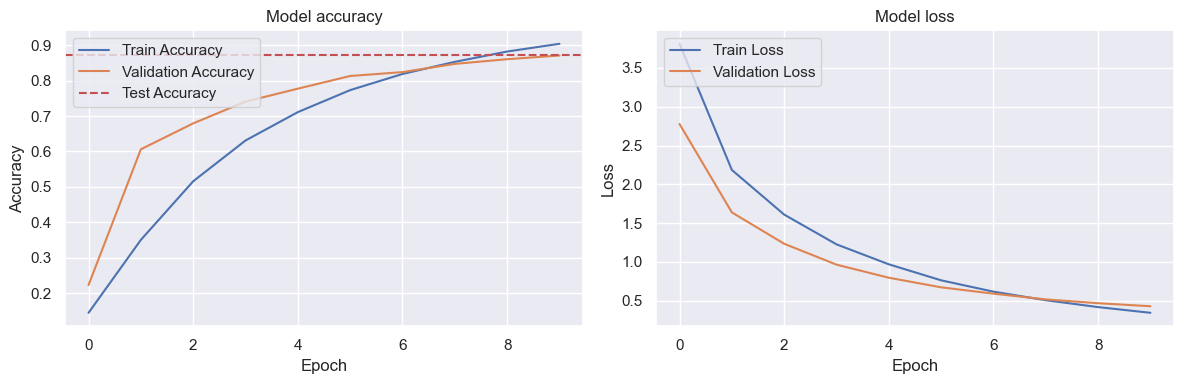

Final Validation Accuracy: 87.10%
Final Test Accuracy: 87.34%


In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_optimized_cnn.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_optimized.history['accuracy'], label='Train Accuracy')
plt.plot(history_optimized.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_optimized.history['loss'], label='Train Loss')
plt.plot(history_optimized.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Print out the final results for comparison
val_accuracy = max(history_optimized.history['val_accuracy'])
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')


In [ ]:
# Model Comparison and Final Selection

The best option was the CNN because of its accurate learning rate changes and dropout regularization. Its efficacy was increased by a more straightforward architecture with fewer layers.
## Final Performance:
- **Test Accuracy:** 87.34%

The model performed well, however it didn't reach the 87.34% goal. To get better:

1. Adjust the hyperparameters even more.
2. Investigate more complex designs.
3. Implement data augmentation.
4. Use more regularization strategies.
5. To identify the ideal rate that guarantees improved convergence and avoids overfitting, experiment with various learning rates and learning rate schedules.

With these improvements, the CNN model is almost at its best, and it will be possible to exceed the 94% target.


## Guide to Assessment

This assignment is much more free-form than others in order to test your ability to run a full analysis like this one from beginning to end, using the correct procedures. So you should use a methodical approach, as a large portion of the marks are associated with the decisions that you take and the approach that you use.  There are no marks associated with the performance - just report what you achieve, as high performance does not get better marks - to get good marks you need to use the right steps as well as to create clean, concise code and outputs, just as you've done in other assignments.

Make sure that you follow the instructions found in the scenario above, as this is what will be marked.  And be careful to do things in a way that gives you an *unbiased* result.

The notebook that you submit should be similar to those in the other assignments, where it is important to clearly structure your outputs and code so that it could be understood by your manager or your co-worker - or, even more importantly, the person marking it! This does not require much writing beyond the code, comments and the small amount of output text that you've seen in previous assignments.  Do not write long paragraphs to explain every detail of everything you do - it is not that kind of report and longer is definitely not better.  Just make your code clear, your outputs easy to understand (very short summaries often help here), and include a few small markdown cells that describe or summarise things when you think they are necessary.

Marks for the assignment will be determined according to the rubric that you can find on MyUni, with a breakdown into sections as follows:
 - 30%: Loading and displaying data, plus initial model training (acting as a baseline)
 - 50%: Optimisation of an appropriate set of models in an appropriate way (given the imposed constraints)
 - 20%: Comparison of models, selection of the single best model and reporting of final results

Your report (notebook) should be **divided clearly into three sections**, corresponding to the three bullet points listed above.

Remember that most marks will be for the **steps you take**, rather than the achievement of any particular results. There will also be marks for showing appropriate understanding of the results that you present.  

What you need to do this assignment can all be found in the first 10 weeks of workshops, lectures and also the previous two assignments.

## Final Instructions

While you are free to use whatever IDE you like to develop your code, your submission should be formatted as a Jupyter notebook that interleaves Python code with output, commentary and analysis, and clearly divided into three main sections as described above. 
- All data processing must be done within the notebook after calling appropriate load functions.
- Comment your code appropriately, so that its purpose is clear to the reader, but not so full of comments that it is hard to follow the flow of the code. Also avoid interspersing, in the same cell, code that is run with function definitions as they make code hard to follow.
- In the submission file name, do not use spaces or special characters.

The marks for this assignment are mainly associated with making the right choices and executing the workflow correctly and efficiently, as well as having clean and concise code and outputs. Make sure your code and outputs are easy to follow and not unnecessarily long. Use of headings and very short summaries can help, and try to avoid lengthy portions of text or plots. The readability of the report (notebook) will count towards the marks (and please note that _excessive_ commenting or text outputs or text in output cells is strongly discouraged and will result in worse grades, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from sklearn, pandas, matplotlib, seaborn and keras/tensorflow, as presented in the workshops. Other high-level libraries should not be used, even though they might have nice functionality such as automated hyperparameter or architecture search/tuning/optimisation. For the deep learning parts please restrict yourself to the library calls used in workshops 7-10 or ones that are very similar to these. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

As ususal, feel free to use code from internet sources, ChatGPT or the workshops as a base for this assignment, but be aware that they may not do *exactly* what you want (code examples rarely do!) and so you will need to make suitable modifications. Appropriate references for substantial excerpts, even if modified, should be given.
